In [1]:
%%capture
import sys
import glob, os
os.chdir('/home/m/m300878/submesoscaletelescope/notebooks/may22/')
sys.path.insert(1, '../')
from icon_smt_levels import dzw, dzt, depthc, depthi
sys.path.insert(1, '/home/m/m300878/submesoscaletelescope/run_batch_job/model_evaluation/')
import eval_funcs as eva

import warnings
warnings.filterwarnings('ignore')  #suppress some warnings about future code changes

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
from scipy import stats    #Used for 2D binned statistics
from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import pyicon as pyic



# sst bias

In [4]:
sst = eva.load_satellite_sst()
sst

<xarray.Dataset>
Dimensions:       (lat: 4320, lon: 8640, time: 90)
Coordinates:
  * lat           (lat) float32 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon           (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time          (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-03-31
Data variables:
    sst_night     (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    sst_night_qf  (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    sst_day       (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    sst_day_qf    (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
Attributes: (12/27)
    Conventions:                CF-1.6
    title:                      MODIS-AQUA Collection 6 daily (mean) sea surf...
    summary:                    MODIS-AQUA Collection 6 daily (mean) sea surf...
    institution:                Center for Earth System Research and Sustaina...
    creator_url:                http://icdc.cen.uni-hamburg.de
    creator_name:               Integrated Climate Data Center (ICDC)
    ...                         ...
    platform:                   EOS-AQUA
    sensor:                     MODIS
    version:                    R2014.0
    source:                     http://oceandata.sci.gsfc.nasa.gov/MODIS-Aqua...
    references:                 1) http://oceancolor.gsfc.nasa.gov/cms/techdo...
    citation:                   NASA Goddard Space Flight Center, Ocean Ecolo...

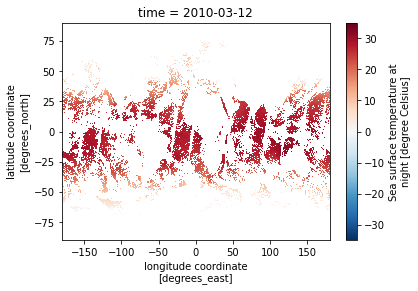

In [5]:
sst.isel(time=70).sst_night.plot()

### interpolate

In [6]:
fpath_ckdtree = '/work/mh0033/from_Mistral/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.30_180W-180E_90S-90N.npz'
ddnpz = np.load(fpath_ckdtree)
lon, lat = ddnpz['lon'], ddnpz['lat']

In [27]:
print('interp')
sst1 = sst.isel(time=79).sst_night
dso = xr.Dataset()

dso = sst1.interp(lon=lon, lat=lat)
#print(f'Saving {fpatho}')
#dso.to_netcdf(fpatho)
#ds_ref = dso

interp


In [14]:
dso

<xarray.DataArray 'sst_night' (lat: 600, lon: 1200)>
dask.array<transpose, shape=(600, 1200), dtype=float32, chunksize=(600, 1200), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2010-03-12
  * lon      (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
  * lat      (lat) float64 -90.0 -89.7 -89.4 -89.1 -88.8 ... 88.8 89.1 89.4 89.7
Attributes:
    long_name:    Sea surface temperature at night
    units:        degree Celsius
    valid_range:  [-200 4500]

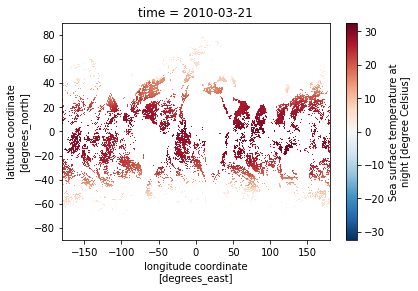

In [28]:
dso.plot()

In [3]:
smt = eva.load_smt_sst()
smt

<xarray.DataArray 'T001_sp' (time: 984, ncells: 59799625)>
dask.array<concatenate, shape=(984, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-09T01:00:00 ... 2010-03-31T23:00:00
Dimensions without coordinates: ncells
Attributes:
    standard_name:                temperature at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [ ]:
smtm = smt.groupby('time.month').mean().compute()

In [10]:
tsmt = 71*12
lon, lat, data = pyic.interp_to_rectgrid(smt.isel(time=tsmt), fpath_ckdtree)


In [43]:
bias = data-dso.data

In [61]:
np.arange(-5.,11, 2)

array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.])

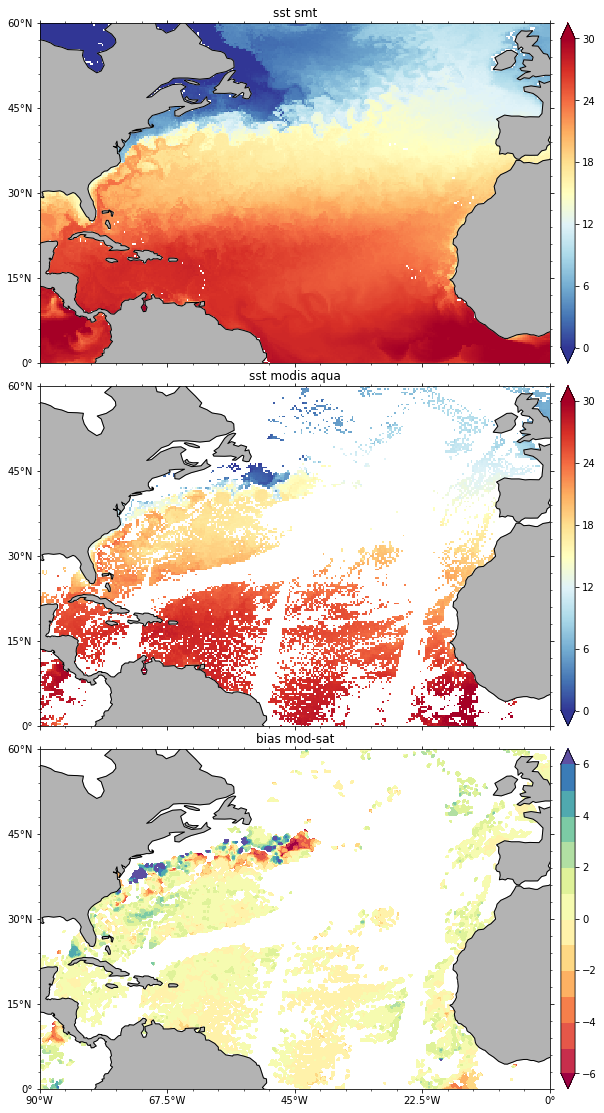

In [68]:
lon_reg = -90,0
lat_reg = 0,60
hca, hcb = pyic.arrange_axes(1, 3, plot_cb=True, asp=0.66, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
clim = 0, 30
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.set_title('sst smt')
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim)
ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.set_title('sst modis aqua')
pyic.shade(dso.lon, dso.lat, dso.data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim)
ii+=1; ax=hca[ii]; cax=hcb[ii]
climb = -5, 5
contfs = np.arange(-6.,7, 1)
#clim = [contfs.min(), contfs.max()]
ax.set_title('bias mod-sat')
pyic.shade(lon, lat, bias, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, contfs=contfs, cmap='Spectral', clim=climb )

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)

plt.savefig(f'../images/sst_bias.png', bbox_inches='tight')   

In [69]:

def load_satellite_monthly_sst():
    path_data  = '/pool/data/ICDC/ocean/modis_aqua_sst/DATA/monthly/2010/'
    search_str = f'MODIS-AQUA__C6__SST_v2019.0__4km__2010*.nc' 

    flist      = np.array(glob.glob(path_data+search_str))
    flist.sort()

    ds = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1))
    return(ds)

In [71]:
sstm = load_satellite_monthly_sst()
sstm

<xarray.Dataset>
Dimensions:       (lat: 4320, lon: 8640, time: 12)
Coordinates:
  * lat           (lat) float32 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon           (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time          (time) datetime64[ns] 2010-01-16 2010-02-13 ... 2010-12-16
Data variables:
    sst_night     (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    sst_night_qf  (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    sst_day       (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    sst_day_qf    (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
Attributes: (12/27)
    Conventions:                CF-1.6
    title:                      MODIS-AQUA Collection 6 monthly (mean) sea su...
    summary:                    MODIS-AQUA Collection 6 monthly (mean) sea su...
    institution:                Center for Earth System Research and Sustaina...
    creator_url:                http://icdc.cen.uni-hamburg.de
    creator_name:               Integrated Climate Data Center (ICDC)
    ...                         ...
    platform:                   EOS-AQUA
    sensor:                     MODIS
    version:                    R2019.0
    source:                     http://oceandata.sci.gsfc.nasa.gov/MODIS-Aqua...
    references:                 1) http://oceancolor.gsfc.nasa.gov/cms/techdo...
    citation:                   NASA Goddard Space Flight Center, Ocean Ecolo...

In [72]:
print('interp')
sst1 = sstm.sst_night
sst_inter = xr.Dataset()

sst_inter = sst1.interp(lon=lon, lat=lat)

interp


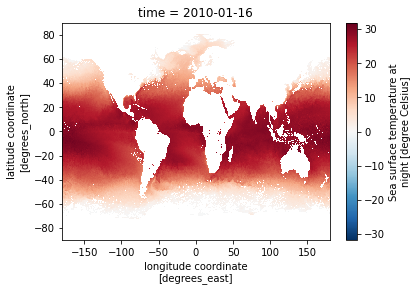

In [73]:
sst_inter.isel(time=0).plot()

In [77]:
bias = data-sst_inter.isel(time=1).data

In [80]:
sst_inter.lat

<xarray.DataArray 'lat' (lat: 600)>
array([-90. , -89.7, -89.4, ...,  89.1,  89.4,  89.7])
Coordinates:
  * lat      (lat) float64 -90.0 -89.7 -89.4 -89.1 -88.8 ... 88.8 89.1 89.4 89.7
Attributes:
    standard_name:  latitude
    long_name:      latitude coordinate
    units:          degrees_north

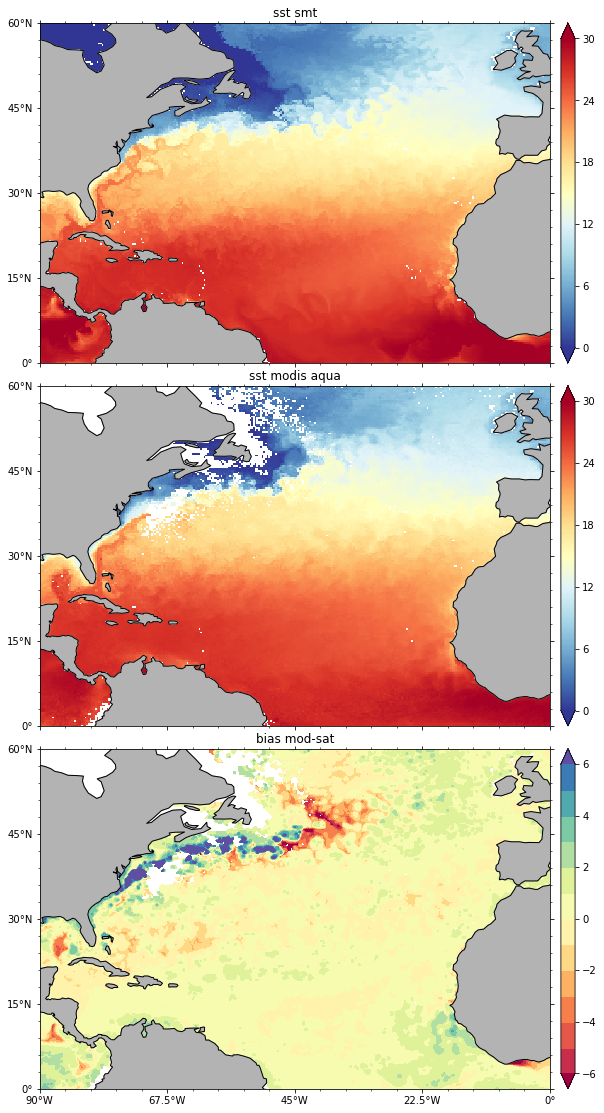

In [81]:
lon_reg = -90,0
lat_reg = 0,60
hca, hcb = pyic.arrange_axes(1, 3, plot_cb=True, asp=0.66, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
clim = 0, 30
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.set_title('sst smt')
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim)
ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.set_title('sst modis aqua')
pyic.shade(sst_inter.lon, sst_inter.lat, sst_inter.isel(time=1).data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim)
ii+=1; ax=hca[ii]; cax=hcb[ii]
climb = -5, 5
contfs = np.arange(-6.,7, 1)
#clim = [contfs.min(), contfs.max()]
ax.set_title('bias mod-sat')
pyic.shade(lon, lat, bias, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, contfs=contfs, cmap='Spectral', clim=climb )

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)

plt.savefig(f'../images/sst_bias.png', bbox_inches='tight')   

In [2]:
smt = load_smt()
fpath_tgrid  = '/home/m/m300602/work/icon/grids/smt/smt_tgrid.nc'
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
f.close()
smt = smt.assign_coords({"clon": ("ncells", clon)})
smt = smt.assign_coords({"clat": ("ncells", clat)})
smt

NameError: name 'load_smt' is not defined

In [51]:
fpath_ckdtree    = '/home/m/m300602/work/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.nc'
lon_reg = [-90, -0]
lat_reg = [0, 90]
interp   = pyic.interp_to_rectgrid_xr(smt.h_sp, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

In [ ]:
lon_reg = [-90, -0]
lat_reg = [0, 90]
t=50*12
fpath_ckdtree    = '/home/m/m300602/work/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.nc'
lon, lat, data = pyic.interp_to_rectgrid_xr(smt.h_sp, fpath_ckdtree)
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=1, fig_size_fac=4, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
#lon, lat, data = pyic.interp_to_rectgrid_xr(smt.h_sp, fpath_ckdtree)
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False)

ax.set_title('ssh smt')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
for ax in hca:
    pyic.plot_settings(ax)

In [ ]:
data